# Image Processing using FSL
<hr/>
***As-Is Software Disclaimer***

This content in this repository is delivered “As-Is”. Notwithstanding anything to the contrary, DNAnexus will have no warranty, support, liability or other obligations with respect to Materials provided hereunder.

<hr/>

This notebook demonstrates usage of the Image Processing package <a href="https://fsl.fmrib.ox.ac.uk/fsl/fslwiki">FSL</a> on the DNAnexus platform, to perform Brain Extraction and Isotropic Smooth as individual analyses and also in the form of a NiPype workflow. 

<a href="https://github.com/dnanexus/OpenBio/blob/master/LICENSE.md">MIT License</a> applies to this notebook.

## 1. Preparing your environment
### Launch spec:

* App name: JupyterLab with Python, R, Stata, ML, Image Processing
* App flavor: IMAGE_PROCESSING
* Kernel: Python
* Instance type: mem1_ssd1_v2_x16
* Runtime: =~ 5 min
* Data description: Input for this notebook is a T1-weighted MRI image. We are downloading the primer example data from <a href="https://www.fmrib.ox.ac.uk/primers/intro_primer/ExBox13/IntroBox13.html">Oxford NeuroImaging Primer</a>. The downloaded zipped folder (size ~30 MB) contains the following images: 
    * Original (non-brain-extracted) structural image: `T1.nii.gz`
    * Two brain extracted images: `T1_v1_brain.nii.gz` and `T1_v2_brain.nii.gz`
    
### Package and tools dependency:

| Package | License | 
| --- | --- |
| <a href="https://graphviz.org/license/">graphviz</a> | <a href="https://opensource.org/licenses/CPL-1.0">Common Public License</a> |

## 2. Download and Unzip an MRI

In [2]:
! wget https://www.fmrib.ox.ac.uk/primers/intro_primer/ExBox13/ExBox13.zip

--2022-08-02 00:42:51--  https://www.fmrib.ox.ac.uk/primers/intro_primer/ExBox13/ExBox13.zip
Resolving www.fmrib.ox.ac.uk (www.fmrib.ox.ac.uk)... 129.67.248.65
Connecting to www.fmrib.ox.ac.uk (www.fmrib.ox.ac.uk)|129.67.248.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31149300 (30M) [application/zip]
Saving to: ‘ExBox13.zip’

ExBox13.zip         100%[===================>]  29.71M  21.5MB/s    in 1.4s    

2022-08-02 00:42:53 (21.5 MB/s) - ‘ExBox13.zip’ saved [31149300/31149300]



In [ ]:
! apt-get update
! apt-get install unzip
! unzip ExBox13.zip
! ls ExBox13/

## 3. Install and Import Packages

In [ ]:
! yes | apt-get install graphviz

In [5]:
from nipype.interfaces import fsl
from nipype import Node, Workflow
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

plt.style.use("seaborn-dark")

## 4. Load MRI and Get Metadata

### Declare input file

In [6]:
mri_dir = "/opt/notebooks/ExBox13/"
t1_filename = "T1.nii.gz"
t1_in_file = os.path.join(mri_dir, t1_filename)
t1_in_file

'/opt/notebooks/ExBox13/T1.nii.gz'

The `nib.load()` function returns an nibabel object and allows us to get metadata about the MRI image without loading the actual image into memory.

In [7]:
t1 = nib.load(t1_in_file)
print("MRI shape:", t1.shape)

MRI shape: (290, 320, 208)


The header attribute contains important metadata for an MRI (e.g. image dimensions, data type, etc.)

In [8]:
print(t1.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 290 320 208   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.          0.8         0.8         0.79999995  2.4         0.
  0.          0.        ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 1040.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL4.0'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.99649286
quatern_d       : 0.08367784
qoffset_x       : 113.95224
qoffs

## 5. Visualize MRI Slices

Set the default output type of images as `*.nifti.gz`

In [9]:
fsl.FSLCommand.set_default_output_type("NIFTI_GZ")

The nibabel object generated above does not load the actual image data. We use the `get_fdata()` function to load the image array data.

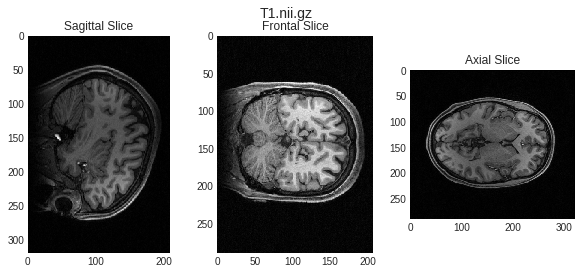

In [10]:
t1_img_data = t1.get_fdata()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("T1.nii.gz", fontsize=14)

ax[0].imshow(t1_img_data[100, :, :], cmap="gray")
ax[0].set_title("Sagittal Slice")

ax[1].imshow(t1_img_data[:, 100, :], cmap="gray")
ax[1].set_title("Frontal Slice")

ax[2].imshow(t1_img_data[:, :, 100], cmap="gray")
ax[2].set_title("Axial Slice")

plt.show()

## 6. Extract Brain image from the whole head
We use the `BET` (Brain Extraction Tool) function to extract only the brain tissue and delete non-brain parts from an image of the whole head.

In [11]:
# Skullstrip process
skullstrip = fsl.BET(
    in_file=t1_in_file, out_file=mri_dir + "/T1_skullstrip.nii.gz", mask=True
)
skullstrip.run()

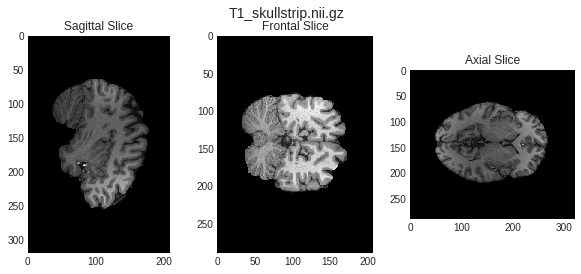

In [12]:
skullstrip_img_data = nib.load(
    os.path.join(mri_dir, "T1_skullstrip.nii.gz")
).get_fdata()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("T1_skullstrip.nii.gz", fontsize=14)

ax[0].imshow(skullstrip_img_data[100, :, :], cmap="gray")
ax[0].set_title("Sagittal Slice")

ax[1].imshow(skullstrip_img_data[:, 100, :], cmap="gray")
ax[1].set_title("Frontal Slice")

ax[2].imshow(skullstrip_img_data[:, :, 100], cmap="gray")
ax[2].set_title("Axial Slice")

plt.show()

## 7. Apply Isotropic Smooth
We use the `IsotropicSmooth()` function to spatially smooth an image by applying a Gaussian filter.

In [13]:
# Smoothing process
smooth = fsl.IsotropicSmooth(
    in_file=t1_in_file, out_file=mri_dir + "/T1_smooth.nii.gz", fwhm=4
)
smooth.run()

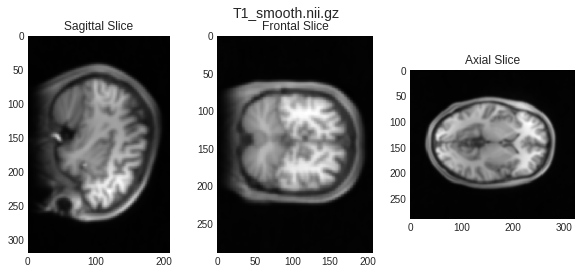

In [14]:
smooth_img_data = nib.load(os.path.join(mri_dir, "T1_smooth.nii.gz")).get_fdata()

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
fig.suptitle("T1_smooth.nii.gz", fontsize=14)
ax[0].imshow(smooth_img_data[100, :, :], cmap="gray")
ax[0].set_title("Sagittal Slice")

ax[1].imshow(smooth_img_data[:, 100, :], cmap="gray")
ax[1].set_title("Frontal Slice")

ax[2].imshow(smooth_img_data[:, :, 100], cmap="gray")
ax[2].set_title("Axial Slice")

plt.show()

## 8. Running a Workflow
So far, we ran analysis on the MRI in the form of individual interfaces. If we want to run multiple interfaces in a specific order, we can build and run a workflow. The workflow is a Directed Acyclic Graph consisting of individual interfaces as nodes and connections between the interfaces as edges. 

For more information information on workflow, visit: https://github.com/miykael/nipype_tutorial/blob/master/notebooks/basic_workflow.ipynb

### Create nodes

In [15]:
# Skullstrip process
skullstrip = Node(fsl.BET(in_file=t1_in_file, mask=True), name="skullstrip")

# Smooth process
smooth = Node(fsl.IsotropicSmooth(in_file=t1_in_file, fwhm=4), name="smooth")

# Mask process
mask = Node(fsl.ApplyMask(), name="mask")

### Initiate workflow

In [16]:
wf = Workflow(name="smoothflow", base_dir=mri_dir)

### Connect nodes to form edges

In [17]:
wf.connect(
    [
        (skullstrip, mask, [("mask_file", "mask_file")]),
        (smooth, mask, [("out_file", "in_file")]),
    ]
)

### Visualize the workflow

220802-00:45:27,135 nipype.workflow INFO:
	 Generated workflow graph: /opt/notebooks/ExBox13/smoothflow/graph.png (graph2use=flat, simple_form=True).


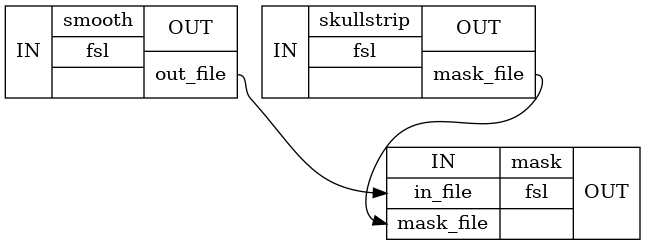

In [18]:
wf.write_graph(graph2use="flat")
from IPython.display import Image

Image(filename=wf.base_dir + "/smoothflow/graph_detailed.png")

### Run the workflow

In [19]:
wf.run()

220802-00:45:30,704 nipype.workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging', 'monitoring']
220802-00:45:30,708 nipype.workflow INFO:
	 Running serially.
220802-00:45:30,709 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.smooth" in "/opt/notebooks/ExBox13/smoothflow/smooth".
220802-00:45:30,711 nipype.workflow INFO:
	 [Node] Executing "smooth" <nipype.interfaces.fsl.maths.IsotropicSmooth>
220802-00:45:39,736 nipype.workflow INFO:
	 [Node] Finished "smooth", elapsed time 9.023464s.
220802-00:45:39,740 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.skullstrip" in "/opt/notebooks/ExBox13/smoothflow/skullstrip".
220802-00:45:39,742 nipype.workflow INFO:
	 [Node] Executing "skullstrip" <nipype.interfaces.fsl.preprocess.BET>
220802-00:45:43,616 nipype.workflow INFO:
	 [Node] Finished "skullstrip", elapsed time 3.87304s.
220802-00:45:43,620 nipype.workflow INFO:
	 [Node] Setting-up "smoothflow.mask" in "/opt/notebooks/ExBox13/smoothflow/mask".
22080

### Visualize the results

In [57]:
# Helper function to plot images
def plot_slice(file_name):

    # Load the image
    img = nib.load(file_name)
    data = img.get_fdata()

    # Cut in the middle of the brain
    cut = int(data.shape[-1] / 2) + 10

    # Plot the data
    plt.title(os.path.basename(file_name))
    plt.imshow(data[..., cut], cmap="gray")
    plt.gca().set_axis_off()

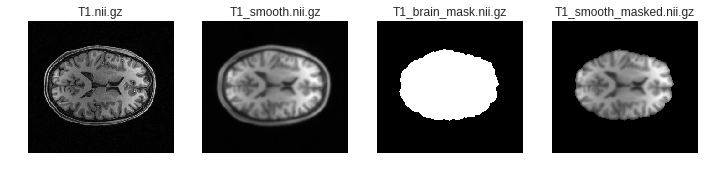

In [59]:
fig = plt.figure(figsize=(12, 4))
for i, img in enumerate(
    [
        t1_in_file,
        wf.base_dir + "/smoothflow/smooth/T1_smooth.nii.gz",
        wf.base_dir + "/smoothflow/skullstrip/T1_brain_mask.nii.gz",
        wf.base_dir + "/smoothflow/mask/T1_smooth_masked.nii.gz",
    ]
):
    fig.add_subplot(1, 4, i + 1)
    plot_slice(img)